![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F05+-+TensorFlow&dt=05+-+Vertex+AI+Custom+Model+-+TensorFlow+-+in+Notebook.ipynb)

# 05 - Vertex AI > Notebooks - Models Built in Notebooks with Tensorflow

>**NOTE:** The notebooks in the `05 - TensorFlow` series demonstrate training, serving and operations for TensorFlow models and take advantage of [Vertex AI TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) to track training across experiments.  Running these notebooks will create a Vertex AI TensorBoard instance which previously (before August 2023) had a subscription cost but is now priced based on storage of which this notebook will create minimal size (<2MB). - [Vertex AI Pricing](https://cloud.google.com/vertex-ai/pricing#tensorboard).

---
---
**Changes In Progress**

Every attempt is being made to ensure the public version of this notebook runs without error while the follow enhancements are being made:
- ~~The workflow of the notebook is being adapted to a Kubeflow Pipeline running on Vertex AI Pipelines~~
- Including Evaluation data within Vertex AI Model Registry
- Update the Vertex AI Experiments integration which has been great simplified within the API over the past few months
- add client library reference links to each section

Order: notebook 05 and 05a will be updated first.  Then 05b-05i will follow quickly.

This note will be removed once these changes are complete.

---
---

Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

This notebook shows training a model directly within the runtime of the notebook environment.  Then the model is saved and moved to GCS for deployment to a Vertex AI > Endpoint for online predictions.  The model training is done with [Tensorflow](https://www.tensorflow.org/), specifically [Keras](https://keras.io/), and was designed to show a neural network approach to logistic regression.  The training data batches are read from BigQuery using [Tensorflow I/O](https://www.tensorflow.org/io).

The other notebooks in this series (`05a-05i`) show how to move the training into a managed compute environment using Vertex AI > Training.  The first step to being able to use a training job is converting the code in this notebook into a training script.  This processs is covered in:
- [05 - Vertex AI Custom Model - TensorFlow - Notebook to Script.ipynb](./05%20-%20Vertex%20AI%20Custom%20Model%20-%20TensorFlow%20-%20Notebook%20to%20Script.ipynb)
- [05 - Vertex AI Custom Model - TensorFlow - Notebook to Hyperparameter Tuning Script.ipynb](./05%20-%20Vertex%20AI%20Custom%20Model%20-%20TensorFlow%20-%20Notebook%20to%20Hyperparameter%20Tuning%20Script.ipynb)

**Video Walkthrough of this notebook:**

Includes conversational walkthrough and more explanatory information than the notebook:

<p align="center" width="100%"><center><a href="https://youtu.be/-5E3hWfsB4I" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/05.png" width="40%"></a></center></p>

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery Tensorflow Reader](https://www.tensorflow.org/io/tutorials/bigquery)
-  [Keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
   -  [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras)
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Tensorflow Python Client](https://www.tensorflow.org/api_docs/python/tf)
-  [Tensorflow I/O Python Client](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- Pre-built Containers for Vertex AI
    - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
    - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/05%20-%20TensorFlow/05%20-%20Vertex%20AI%20Custom%20Model%20-%20TensorFlow%20-%20in%20Notebook.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '05'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters
EPOCHS = 4
BATCH_SIZE = 100

packages:

In [341]:
from google.cloud import bigquery

from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf

from google.cloud import aiplatform
from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np
import pandas as pd
from sklearn import metrics as metrics

clients:

In [4]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
DIR = f"temp/{EXPERIMENT}"

environment:

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

Experiment Tracking:

In [7]:
FRAMEWORK = 'tf'
TASK = 'classification'
MODEL_TYPE = 'dnn'
EXPERIMENT_NAME = f'experiment-{SERIES}-{EXPERIMENT}-{FRAMEWORK}-{TASK}-{MODEL_TYPE}'
RUN_NAME = f'run-{TIMESTAMP}'

---
## Get Vertex AI Experiments Tensorboard Instance Name
[Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) has managed [Tensorboard](https://www.tensorflow.org/tensorboard) instances that you can track Tensorboard Experiments (a training run or hyperparameter tuning sweep).  

The training job will show up as an experiment for the Tensorboard instance and have the same name as the training job ID.

This code checks to see if a Tensorboard Instance has been created in the project, retrieves it if so, creates it otherwise:

In [8]:
tb = aiplatform.Tensorboard.list(filter=f"labels.series={SERIES}")
if tb:
    tb = tb[0]
else: 
    tb = aiplatform.Tensorboard.create(display_name = SERIES, labels = {'series' : f'{SERIES}'})

In [9]:
tb.resource_name

'projects/1026793852137/locations/us-central1/tensorboards/7876136041294331904'

---
## Setup Vertex AI Experiments

The code in this section initializes the experiment and starts a run that represents this notebook.  Throughout the notebook sections for model training and evaluation information will be logged to the experiment using:
- [.log_params](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_params)
- [.log_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_metrics)
- [.log_time_series_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_time_series_metrics)

Initialize the Experiment:

In [10]:
aiplatform.init(experiment = EXPERIMENT_NAME, experiment_tensorboard = tb.resource_name)

Create an experiment run:

In [11]:
if RUN_NAME in [run.name for run in aiplatform.ExperimentRun.list(experiment = EXPERIMENT_NAME)]:
    expRun = aiplatform.ExperimentRun(run_name = RUN_NAME, experiment = EXPERIMENT_NAME)
    print('This run already exist with, using previous.')
else:
    expRun = aiplatform.ExperimentRun.create(run_name = RUN_NAME, experiment = EXPERIMENT_NAME)
    print('Starting a new run.')

Associating projects/1026793852137/locations/us-central1/metadataStores/default/contexts/experiment-05-05-tf-classification-dnn-run-20230327115749 to Experiment: experiment-05-05-tf-classification-dnn
Starting a new run.


Log parameters to the experiment run:

In [12]:
expRun.log_params({'experiment': EXPERIMENT, 'series': SERIES, 'project_id': PROJECT_ID})

---
## Training Data
In this exercise the data source is a table in Google BigQuery.  While it is possible to bring the entire table into the local notebook as a Pandas dataframe, it is not a scalable solution for very large training tables.  In this section the connection to BigQuery is done using Tensorflow I/O to read batches of training data in parallel during model training.

### Data Schema
Using BigQueries Information_Schema is an easy way to quickly retrieve the column information about our training data.  In this case we need the column names and data types to setup the data reading and the model inputs.  This section retrieves the column information for the training table source.

In [13]:
query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{BQ_TABLE}'"
schema = bq.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,statmike-mlops-349915,fraud,fraud_prepped,Time,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
1,statmike-mlops-349915,fraud,fraud_prepped,V1,2,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
2,statmike-mlops-349915,fraud,fraud_prepped,V2,3,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
3,statmike-mlops-349915,fraud,fraud_prepped,V3,4,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
4,statmike-mlops-349915,fraud,fraud_prepped,V4,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
5,statmike-mlops-349915,fraud,fraud_prepped,V5,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
6,statmike-mlops-349915,fraud,fraud_prepped,V6,7,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
7,statmike-mlops-349915,fraud,fraud_prepped,V7,8,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
8,statmike-mlops-349915,fraud,fraud_prepped,V8,9,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
9,statmike-mlops-349915,fraud,fraud_prepped,V9,10,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None


### Number of Classes for the Label Column: VAR_TARGET
This is a supervised learning example that classifies examples into the classes found in the label column stored in the variable `VAR_TARGET`.

In [14]:
nclasses = bq.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,Class
0,0
1,1


In [15]:
nclasses = nclasses.shape[0]
nclasses

2

In [16]:
expRun.log_params({'data_source': f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}', 'nclasses': nclasses, 'var_split': 'splits', 'var_target': VAR_TARGET})

### Selected Columns and Data Types

Use the the table schema to prepare the TensorFlow model inputs:
- Omit unused columns
- Create list of `selected_fields` from the training source
- Define the data types, `output_types`, using the schema data and remapping to desired precision if needed

In [17]:
# Make a list of columns to omit
OMIT = VAR_OMIT.split() + ['splits']

# use schema to prepare a list of columns to read from BigQuery
selected_fields = schema[~schema.column_name.isin(OMIT)].column_name.tolist()

# all the columns in this data source are either float64 or int64
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in schema[~schema.column_name.isin(OMIT)].data_type.tolist()]

---
## Read From BigQuery Using TensorFlow I/O 

### Divide the inputs into features and target

Define a function that remaps the input data for TensorFlow into:
- features
- `target` - one_hot encoded for multi-class classification and also works for binary classification

In [18]:
def transTable(row_dict):
    target = row_dict.pop(VAR_TARGET)
    target = tf.one_hot(tf.cast(target,tf.int64), nclasses)
    target = tf.cast(target, tf.float32)
    return(row_dict, target)

### Setup Tensorflow I/O to Read Batches from BigQuery

Setup TensorFlow_IO client > session > table + table.map
- https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryClient

In [139]:
def bq_reader(split):
    reader = BigQueryClient()

    training = reader.read_session(
        parent = f"projects/{PROJECT_ID}",
        project_id = BQ_PROJECT,
        table_id = BQ_TABLE,
        dataset_id = BQ_DATASET,
        selected_fields = selected_fields,
        output_types = output_types,
        row_restriction = f"splits='{split}'",
        requested_streams = 3
    )
    
    return training.parallel_read_rows(sloppy = True, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [126]:
bq_reader('TRAIN')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'projects/statmike-mlops-349915/locations/us-central1/streams/EgxYcVYxOFFDbjhiSEEaAmp0GgJqcygB'>

In [140]:
train = bq_reader('TRAIN').prefetch(1).map(transTable).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
validate = bq_reader('VALIDATE').prefetch(1).map(transTable).batch(BATCH_SIZE)
test = bq_reader('TEST').prefetch(1).map(transTable).batch(BATCH_SIZE)

In [108]:
expRun.log_params({'training.batch_size': BATCH_SIZE, 'training.shuffle': 10*BATCH_SIZE, 'training.prefetch': 1})

Review a single batch of the train data:

In [144]:
for features, target in train.take(1):
    print('features:\n',list(features.keys()))
    print('\ntarget:\n',target[0:10])

2023-03-28 10:16:32.220760: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-28 10:16:32.220821: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


features:
 ['Amount', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']

target:
 tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


---
## Define the Model: In The Notebook (local runtime)

Define the Model:
- Building the model using the [Keras functional api](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
- This is basically multi-class logistic regression where the feature space is mapped to the number of classes in the target by a [softmax activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)
- The [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) is made up of `inputs` and `outputs`
    - the inputs are a list of [keras.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) tensors that was constructed above
    - the outputs are a group of [keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
        - connects each input to a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of features
        - connecting to a [BatchNormalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
            - for each batch of inputs it scales each feature to have mean = 0 and standard deviation = 1 for the batch
            - Note on Normalization - If you are using TensorFlow 2.6 or higher then you can also try a normalization layer with the [adapt method](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt) as a preprocessing layer (does not update during training).
        - ending with a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of class levels in the target

Adding metrics to the model:
- Specifying 'accuracy' triggers conversion to [tf.keras.metrics.CategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy) due to the loss function being [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
- If the target variable is highly imbalanced then it is good to consider the area under the precision-recall curve.  This is requested with [tf.keras.metrics.AUC(curve='PR')](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC)

In [23]:
# Logistic Regression

# model input definitions
feature_columns = {header: tf.feature_column.numeric_column(header) for header in selected_fields if header != VAR_TARGET}
feature_layer_inputs = {header: tf.keras.layers.Input(shape = (1,), name = header) for header in selected_fields if header != VAR_TARGET}

# feature columns to a Dense Feature Layer
feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns.values(), name = 'feature_layer')(feature_layer_inputs)

# batch normalization of inputs
normalized = tf.keras.layers.BatchNormalization(name = 'batch_normalization_layer')(feature_layer_outputs)

# logistic - using softmax activation to nclasses
logistic = tf.keras.layers.Dense(nclasses, activation = tf.nn.softmax, name = 'logistic')(normalized)

# the model
model = tf.keras.Model(
    inputs = feature_layer_inputs,
    outputs = logistic,
    name = EXPERIMENT
)

# compile
model.compile(
    optimizer = tf.keras.optimizers.SGD(), #SGD or Adam
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.AUC(curve = 'PR', name = 'auprc')]
)

In [24]:
!pip install graphviz

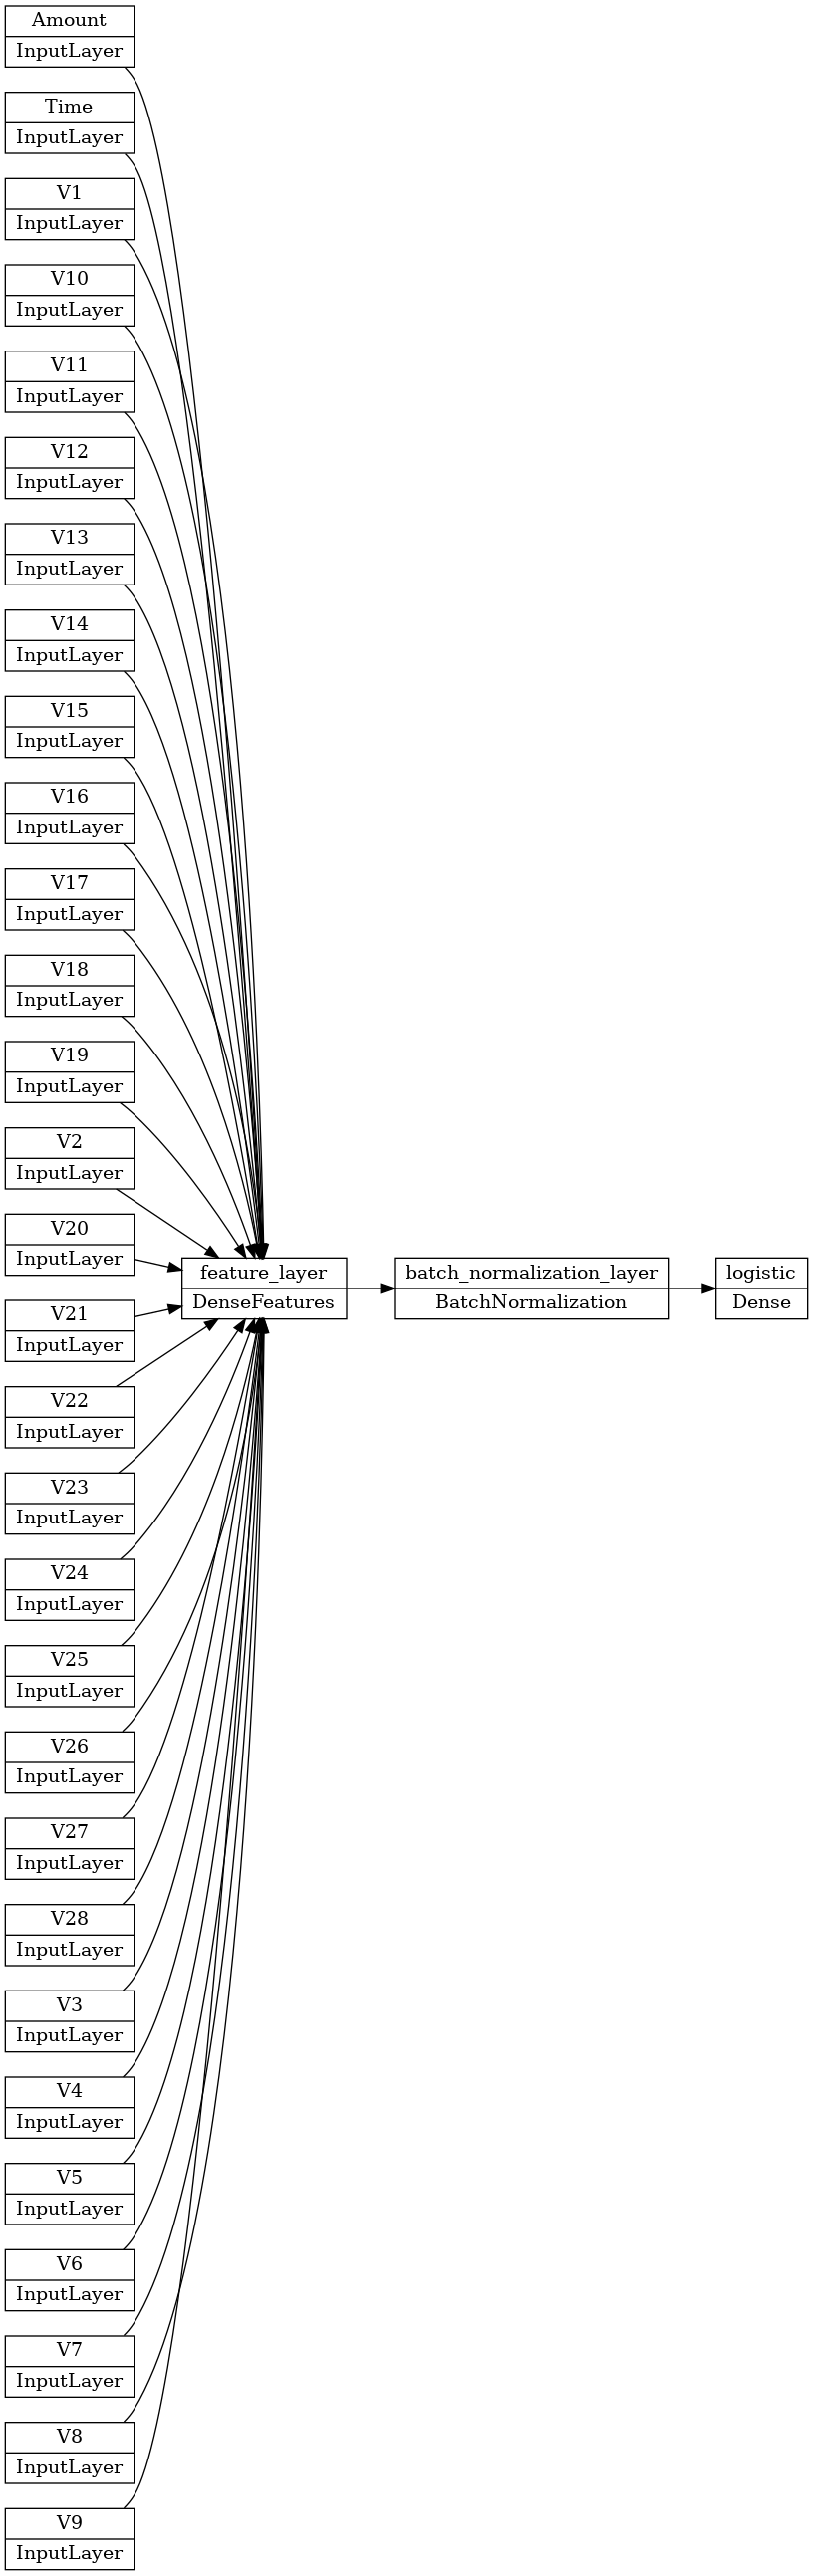

In [25]:
tf.keras.utils.plot_model(model, rankdir='LR')

In [26]:
model.summary()

Model: "05"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Amount (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Time (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 V1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 V10 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                 

---
## Train The Model: In The Notebook (local runtime)

Fit the Model:

In [27]:
# setup tensorboard logs and train
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(DIR, "logs", f'{TIMESTAMP}'), histogram_freq=1)
history = model.fit(train, epochs = EPOCHS, callbacks = [tensorboard_callback], validation_data = validate)

Epoch 1/4


2023-03-27 11:58:05.341196: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:58:05.341274: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


   2279/Unknown - 28s 11ms/step - loss: 0.0589 - accuracy: 0.9835 - auprc: 0.9976

2023-03-27 11:58:33.539060: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:58:33.539121: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2281/2281 [==============================] - 34s 14ms/step - loss: 0.0589 - accuracy: 0.9835 - auprc: 0.9976 - val_loss: 0.0125 - val_accuracy: 0.9989 - val_auprc: 0.9990
Epoch 2/4


2023-03-27 11:58:37.771880: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:58:37.771958: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2281 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9991 - auprc: 0.9995

2023-03-27 11:59:03.958946: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:59:03.959001: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2281/2281 [==============================] - 31s 13ms/step - loss: 0.0079 - accuracy: 0.9991 - auprc: 0.9995 - val_loss: 0.0089 - val_accuracy: 0.9990 - val_auprc: 0.9992
Epoch 3/4


2023-03-27 11:59:08.330892: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:59:08.330962: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2276/2281 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9991 - auprc: 0.9994

2023-03-27 11:59:33.695720: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:59:33.695781: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2281/2281 [==============================] - 30s 13ms/step - loss: 0.0067 - accuracy: 0.9991 - auprc: 0.9994 - val_loss: 0.0078 - val_accuracy: 0.9991 - val_auprc: 0.9993
Epoch 4/4


2023-03-27 11:59:38.004232: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 11:59:38.004287: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2271/2281 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9992 - auprc: 0.9994

2023-03-27 12:00:05.475805: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:00:05.475885: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2281/2281 [==============================] - 32s 14ms/step - loss: 0.0059 - accuracy: 0.9992 - auprc: 0.9994 - val_loss: 0.0072 - val_accuracy: 0.9990 - val_auprc: 0.9993


In [28]:
history.history['loss'][-1]

0.005903232377022505

In [29]:
expRun.log_params({'training.epochs': history.params['epochs']})
history.params

{'verbose': 1, 'epochs': 4, 'steps': None}

Log the time series metrics to the experiments TensorBoard:

In [30]:
for e in range(0, history.params['epochs']):
    expRun.log_time_series_metrics(
        {
            'train_loss': history.history['loss'][e],
            'train_accuracy': history.history['accuracy'][e],
            'train_auprc': history.history['auprc'][e],
            'val_loss': history.history['val_loss'][e],
            'val_accuracy': history.history['val_accuracy'][e],
            'val_auprc': history.history['val_auprc'][e]
        }, step = e
    )

---
## Evaluate The Model: In The Notebook (local runtime)

Evaluate the model with the test data:

In [31]:
loss, accuracy, auprc = model.evaluate(test)

2023-03-27 12:00:11.332387: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:00:11.332457: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


286/286 [==============================] - 3s 9ms/step - loss: 0.0069 - accuracy: 0.9992 - auprc: 0.9994


In [32]:
expRun.log_metrics({'test_loss': loss, 'test_accuracy': accuracy, 'test_auprc': auprc})

In [33]:
loss, accuracy, auprc = model.evaluate(validate)

2023-03-27 12:00:14.771579: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:00:14.771639: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


283/283 [==============================] - 3s 8ms/step - loss: 0.0072 - accuracy: 0.9990 - auprc: 0.9993


In [34]:
expRun.log_metrics({'val_loss': loss, 'val_accuracy': accuracy, 'val_auprc': auprc})

In [35]:
loss, accuracy, auprc = model.evaluate(train)

2023-03-27 12:00:17.857479: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:00:17.857540: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2281/2281 [==============================] - 25s 11ms/step - loss: 0.0075 - accuracy: 0.9992 - auprc: 0.9994


In [36]:
expRun.log_metrics({'train_loss': loss, 'train_accuracy': accuracy, 'train_auprc': auprc})

---
## Custom Evaluation

Using the test data, calculate a series of metrics using [scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html).  Using TFIO to read the batches from BigQuery means the first step is getting the predictions and actual values into numpy arrays:

In [37]:
predictions = model.predict(test)

actuals = np.empty(shape = [0, predictions.shape[1]])
for features, target in test.take(-1): # -1 indicates all batches
    actuals = np.append(actuals, target.numpy(), axis = 0)

predictions_proba = np.max(predictions, axis = 1)
predictions = np.argmax(predictions, axis = 1)
actuals = np.argmax(actuals, axis = 1)

2023-03-27 12:01:01.081254: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:01:01.081320: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


286/286 [==============================] - 4s 9ms/step


2023-03-27 12:01:05.314925: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:01:05.314986: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


In [159]:
actuals[-20:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [160]:
predictions[-20:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Calculate metrics:

In [39]:
metrics.log_loss(actuals, predictions)

0.027871667036082223

In [40]:
metrics.accuracy_score(actuals, predictions)

0.9991930390849765

In [343]:
metrics.average_precision_score(actuals, predictions)

0.5452071299214538

---
## Evaluate The Training With Tensorboard (Local to Notebook)

Visual ML

Resource: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [45]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir $DIR/logs

---
## Save The Model

Create Prediction from a batch of the test data and review first row:

In [47]:
model.predict(test.take(1))[0]

2023-03-27 12:01:48.976412: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2023-03-27 12:01:48.976474: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


1/1 [==============================] - 2s 2s/step


array([0.99728376, 0.0027162 ], dtype=float32)

Save The Model

In [48]:
model.save(f'{URI}/models/{TIMESTAMP}/model')

INFO:tensorflow:Assets written to: gs://statmike-mlops-349915/05/05/models/20230327115749/model/assets


INFO:tensorflow:Assets written to: gs://statmike-mlops-349915/05/05/models/20230327115749/model/assets


In [49]:
expRun.log_params({'model.save': f'{URI}/models/{TIMESTAMP}/model'})

### Review The Saved Model

#### Keras Model Load

In [50]:
keras_model = tf.keras.models.load_model(f'{URI}/models/{TIMESTAMP}/model')

In [51]:
keras_model.name

'05'

In [52]:
keras_model.inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Amount')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Time')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V12')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V13')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V14')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V15')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V16')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V17')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V18')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'V19')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

In [53]:
keras_model.output.name

'logistic/Softmax:0'

In [54]:
keras_model.summary()

Model: "05"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Amount (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Time (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 V1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 V10 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                 

#### TensorFlow Model Load

In [55]:
tf_model = tf.saved_model.load(f'{URI}/models/{TIMESTAMP}/model')

In [56]:
tf_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, V27, V11, V7, V5, V3, Time, V25, V21, V22, V15, Amount, V10, V4, V26, V17, V28, V6, V2, V16, V12, V24, V14, V9, V1, V13, V8, V19, V18, V20, V23) at 0x7F6F7849F090>})

In [57]:
tf_model.signatures['serving_default']

<ConcreteFunction signature_wrapper(*, V27, V11, V7, V5, V3, Time, V25, V21, V22, V15, Amount, V10, V4, V26, V17, V28, V6, V2, V16, V12, V24, V14, V9, V1, V13, V8, V19, V18, V20, V23) at 0x7F6F7849F090>

In [58]:
tf_model.signatures['serving_default'].structured_input_signature[1].keys()

dict_keys(['V27', 'V11', 'V7', 'V5', 'V3', 'Time', 'V25', 'V21', 'V22', 'V15', 'Amount', 'V10', 'V4', 'V26', 'V17', 'V28', 'V6', 'V2', 'V16', 'V12', 'V24', 'V14', 'V9', 'V1', 'V13', 'V8', 'V19', 'V18', 'V20', 'V23'])

In [59]:
tf_model.signatures['serving_default'].structured_outputs

{'logistic': TensorSpec(shape=(None, 2), dtype=tf.float32, name='logistic')}

#### TensorFlow SavedModel CLI

To see the input and output specification for the TensorFlow model use the [SavedModel CLI](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface):

In [ ]:
# Inspect model inputs and outpus with SavedModel CLI
!saved_model_cli show --dir {URI}/models/{TIMESTAMP}/model --all

---
## Model Explainability - Feature-Based Attributions

This will bring the concepts of [05Tools - Explainability - Feature-Based.ipynb](./05Tools%20-%20Explainability%20-%20Feature-Based.ipynb) into the workflow.

---
## Serving

### Vertex AI Model Registry - Add Model/Version

Check to see if this model has been added to the Vertex AI Model Registry previously.  Add the current model as a a new model, or new version on an existing model.

In [60]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model = modelmatch[0].resource_name

else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'experiment_name' : f'{EXPERIMENT_NAME}', 'run_name' : f'{RUN_NAME}'}        
    )

Model Already in Registry:
Loading model as new default version.
Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_05/operations/1395049152047480832


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_05/operations/1395049152047480832


Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_05_05@13


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_05_05@13


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_05_05@13')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_05_05@13')


>**Note** on Version Aliases:
>Expectation is a name starting with `a-z` that can include `[a-zA-Z0-9-]`
>
>**Retrieve a Model Resource**
>[aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)
>```Python
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}') # retrieves default version
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}@time-{TIMESTAMP}') # retrieves specific version
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}', version = f'time-{TIMESTAMP}') # retrieves specific version
```

In [61]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_05?project=statmike-mlops-349915


### Add Custom Model Evaluation to The Model Registry

The initial evauation of the model was done right after training.  Some of the metrics were written to Vertex AI Experiments above as part of this run.  This section will write evaluation metrics directly to the Model Registry to accompany this version of the trained model.

**Resources:**
- Doc: [Model Evaluation in Vertex AI](https://cloud.google.com/vertex-ai/docs/evaluation/introduction#tabular)
- API: [aiplatform.gapic.ModelServiceClient.import_model_evaluation](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service.ModelServiceClient#google_cloud_aiplatform_v1_services_model_service_ModelServiceClient_import_model_evaluation)
- Example: [Get started with importing a custom model evaluation to the Vertex AI Model Registry](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_evaluation/get_started_with_custom_model_evaluation_import.ipynb)

**Helpful Notes:**
- Evaluations are loaded to a versioned model in the Vertex AI Model Registry.
- Multiple evaluations can be loaded for the same model and version.
- When loading an evaluation you must provide a schema file for the parameter `metrics_schema_uri`.
- A complete list of these is provided by the Doc link above and can be directly reviewed at this [public GCS bucket](https://console.cloud.google.com/storage/browser/google-cloud-aiplatform/schema/modelevaluation).
    - Make sure to use the `gsutil URI` in the API call.

Prepare metrics across a range of confidence thresholds:

In [333]:
cm = []
#for threshold in np.linspace(-0.005, 1.005, 202):
for x in range(0, 203):
    threshold = round(-0.005+x*0.005, 3)
    preds = (predictions_proba < threshold).astype('float')
    conmatrix = metrics.confusion_matrix(actuals, preds).astype(int)
    FP = conmatrix.sum(axis = 0) - np.diag(conmatrix)
    FP = FP[-1]
    FN = conmatrix.sum(axis = 1) - np.diag(conmatrix)
    FN = FN[-1]
    TP = np.diag(conmatrix)
    TP = TP[-1]
    TN = conmatrix.sum() - (FP + FN + TP)
    confidenceThreshold = threshold
    if np.unique(preds).size < np.unique(actuals).size: precision = 0
    else: precision = metrics.precision_score(actuals, preds)
    recall = metrics.recall_score(actuals, preds)
    
    if precision > 0 or recall > 0:
        if confidenceThreshold > 0 or confidenceThreshold < 0: current_threshold = {"confidenceThreshold": threshold}
        else: current_threshold = {}
        if precision > 0: current_threshold['precision'] = precision
        if recall > 0: current_threshold['recall'] = recall
        falsePositiveRate = FP / (FP + TN)
        if falsePositiveRate > 0: current_threshold['falsePositiveRate'] = falsePositiveRate
        f1Score = metrics.f1_score(actuals, preds)
        if f1Score > 0: current_threshold['f1Score'] = f1score
        truePositiveCount = TP
        if truePositiveCount > 0: current_threshold['truePositiveCount'] = str(truePositiveCount)
        falsePositiveCount = FP
        if falsePositiveCount > 0: current_threshold['falsePositiveCount'] = str(falsePositiveCount)
        trueNegativeCount = TN
        if trueNegativeCount > 0: current_threshold['trueNegativeCount'] = str(trueNegativeCount)
        falseNegativeCount = FN
        if falseNegativeCount > 0: current_threshold['falseNegativeCount'] = str(falseNegativeCount)

        current_threshold.update({
            "confusionMatrix": {
                "annotationSpecs": [{"id": "0", "displayName": '0'}, {"id": "1", "displayName": '1'}],
                "rows": [{"dataItemCounts": row} for row in conmatrix.tolist()]
            }
        })
        cm.append(current_threshold)

In [342]:
cm[0]

{'confidenceThreshold': 0.525,
 'precision': 1.0,
 'recall': 0.02127659574468085,
 'f1Score': 0.0022698151198974922,
 'truePositiveCount': '1',
 'trueNegativeCount': '28455',
 'falseNegativeCount': '46',
 'confusionMatrix': {'annotationSpecs': [{'id': '0', 'displayName': '0'},
   {'id': '1', 'displayName': '1'}],
  'rows': [{'dataItemCounts': [28455, 0]}, {'dataItemCounts': [46, 1]}]}}

Combine overall metrics with metrics across thresholds:

In [335]:
model_metrics = {
    "auPrc": metrics.average_precision_score(actuals, predictions),
    "auRoc": metrics.roc_auc_score(actuals, predictions),
    "logLoss": metrics.log_loss(actuals, predictions),
    "confidenceMetrics": cm,
    "confusionMatrix": {
        "annotationSpecs": [{"id": "0", "displayName": '0'}, {"id": "1", "displayName": '1'}],
        "rows": [{"dataItemCounts": row} for row in metrics.confusion_matrix(actuals, predictions).astype(int).tolist()]
    }
}

Setup the `aiplatform.gapic` (v1) aiplatform client:
- more on [API versions](../Tips/aiplatform_notes.md)

In [344]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {'api_endpoint': f"{REGION}-aiplatform.googleapis.com"}
)

In [337]:
eval_upload = model_client.import_model_evaluation(
    parent = model.resource_name,
    model_evaluation = aiplatform.gapic.ModelEvaluation(
        display_name = 'custom_at_training',
        metrics_schema_uri = 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml',
        metrics = model_metrics
    )
)

In [340]:
print(f"Review the evaluation in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{eval_upload.name.split('/')[-1]}?project={PROJECT_ID}")

Review the evaluation in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_05/versions/13/evaluations/7910449600566253824?project=statmike-mlops-349915


<p align="center" width="100%"><center><img src="../architectures/notebooks/05/05_eval.png" width="75%"></center></p>

### Vertex AI Experiments - Update and Review

In [62]:
expRun.log_params({
    'model.uri': model.uri,
    'model.display_name': model.display_name,
    'model.name': model.name,
    'model.resource_name': model.resource_name,
    'model.version_id': model.version_id,
    'model.versioned_resource_name': model.versioned_resource_name
})

Complete the experiment run:

In [63]:
expRun.update_state(state = aiplatform.gapic.Execution.State.COMPLETE)

Retrieve the experiment:

In [64]:
exp = aiplatform.Experiment(experiment_name = EXPERIMENT_NAME)

In [65]:
exp.backing_tensorboard_resource_name

'projects/1026793852137/locations/us-central1/tensorboards/7876136041294331904'

In [66]:
exp.get_data_frame()

,experiment_name,run_name,run_type,state,param.experiment,param.model.uri,param.model.display_name,param.model.resource_name,param.training.shuffle,param.training.prefetch,...,metric.train_loss,metric.test_auprc,metric.test_loss,metric.train_accuracy,time_series_metric.train_accuracy,time_series_metric.train_loss,time_series_metric.train_auprc,time_series_metric.val_auprc,time_series_metric.val_loss,time_series_metric.val_accuracy
0,experiment-05-05-tf-classification-dnn,run-20230327111418,system.ExperimentRun,COMPLETE,05,gs://statmike-mlops-349915/05/05/models/202303...,05_05,projects/1026793852137/locations/us-central1/m...,1000.0,1.0,...,0.007545,0.999431,0.005819,0.999180,0.999132,0.006084,0.999499,0.999233,0.007015,0.999079
1,experiment-05-05-tf-classification-dnn,run-20230327110946,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,1000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,experiment-05-05-tf-classification-dnn,run-20230327105815,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,experiment-05-05-tf-classification-dnn,run-20230327102042,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,experiment-05-05-tf-classification-dnn,run-20230327095945,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,experiment-05-05-tf-classification-dnn,run-20230327095258,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,experiment-05-05-tf-classification-dnn,run-20230327094405,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,experiment-05-05-tf-classification-dnn,run-20230327094201,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,experiment-05-05-tf-classification-dnn,run-20230327094104,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,experiment-05-05-tf-classification-dnn,run-20230327093948,system.ExperimentRun,RUNNING,05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Review the Experiments TensorBoard to compare runs:

In [67]:
print(f"The Experiment TensorBoard Link:\nhttps://{REGION}.tensorboard.googleusercontent.com/experiment/{tb.resource_name.replace('/', '+')}+experiments+{exp.name}")

The Experiment TensorBoard Link:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+1026793852137+locations+us-central1+tensorboards+7876136041294331904+experiments+experiment-05-05-tf-classification-dnn


In [68]:
expRun.get_time_series_data_frame()

,step,wall_time,train_accuracy,train_loss,train_auprc,val_auprc,val_loss,val_accuracy
0,1,2023-03-27 11:24:50.294000+00:00,0.998948,0.009058,0.999429,0.999212,0.008388,0.999079
1,2,2023-03-27 11:24:50.413000+00:00,0.999048,0.006842,0.999496,0.999215,0.007494,0.999079
2,3,2023-03-27 11:24:50.547000+00:00,0.999132,0.006084,0.999499,0.999233,0.007015,0.999079


### Review Experiment and Run in Console

In [69]:
print(f'Review The Experiment in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/experiments/{EXPERIMENT_NAME}?project={PROJECT_ID}')

Review The Experiment in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/experiments/experiment-05-05-tf-classification-dnn?project=statmike-mlops-349915


In [70]:
print(f'Review The Experiment Run in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/experiments/{EXPERIMENT_NAME}/runs/{EXPERIMENT_NAME}-{RUN_NAME}?project={PROJECT_ID}')

Review The Experiment Run in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/experiments/experiment-05-05-tf-classification-dnn/runs/experiment-05-05-tf-classification-dnn-run-20230327111418?project=statmike-mlops-349915


### Compare This Run Using Experiments

Get a list of all experiments in this project:

In [71]:
experiments = aiplatform.Experiment.list()

Remove experiments not in the SERIES:

In [72]:
experiments = [e for e in experiments if e.name.split('-')[0:2] == ['experiment', SERIES]]

Combine the runs from all experiments in SERIES into a single dataframe:

In [73]:
results = []
for experiment in experiments:
        results.append(experiment.get_data_frame())
        print(experiment.name)
results = pd.concat(results)

experiment-05-05f-tf-classification-dnn
experiment-05-05i-tf-classification-dnn
experiment-05-05h-tf-classification-dnn
experiment-05-05g-tf-classification-dnn
experiment-05-05e-tf-classification-dnn
experiment-05-05d-tf-classification-dnn
experiment-05-05c-tf-classification-dnn
experiment-05-05b-tf-classification-dnn
experiment-05-05a-tf-classification-dnn
experiment-05-05-tf-classification-dnn


Create ranks for models within experiment and across the entire SERIES:

In [74]:
def ranker(metric = 'metric.test_auprc'):
    ranks = results[['experiment_name', 'run_name', 'param.model.display_name', 'param.model.version_id', metric]].copy().reset_index(drop = True)
    ranks['series_rank'] = ranks[metric].rank(method = 'dense', ascending = False)
    ranks['experiment_rank'] = ranks.groupby('experiment_name')[metric].rank(method = 'dense', ascending = False)
    return ranks.sort_values(by = ['experiment_name', 'run_name'])
    
ranks = ranker('metric.test_auprc')
ranks

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_auprc,series_rank,experiment_rank
80,experiment-05-05-tf-classification-dnn,run-20230210115433,05_05,6,0.999130,66.0,8.0
79,experiment-05-05-tf-classification-dnn,run-20230213133609,NaN,NaN,0.999309,57.0,5.0
78,experiment-05-05-tf-classification-dnn,run-20230308225745,05_05,7,0.999469,42.0,2.0
77,experiment-05-05-tf-classification-dnn,run-20230324103811,05_05,8,0.999299,59.0,6.0
76,experiment-05-05-tf-classification-dnn,run-20230324104933,NaN,NaN,0.999469,43.0,3.0
...,...,...,...,...,...,...,...
20,experiment-05-05i-tf-classification-dnn,run-20230211221928-5,NaN,NaN,0.999584,9.0,7.0
19,experiment-05-05i-tf-classification-dnn,run-20230211221928-6,NaN,NaN,0.999538,24.0,13.0
18,experiment-05-05i-tf-classification-dnn,run-20230211221928-7,NaN,NaN,0.999538,25.0,14.0
17,experiment-05-05i-tf-classification-dnn,run-20230211221928-8,NaN,NaN,0.999584,4.0,3.0


In [75]:
current_rank = ranks.loc[(ranks['param.model.display_name'] == model.display_name) & (ranks['param.model.version_id'] == model.version_id)]
current_rank

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_auprc,series_rank,experiment_rank
62,experiment-05-05-tf-classification-dnn,run-20230327111418,05_05,12,0.999431,49.0,4.0


In [76]:
print(f"The current model is ranked {current_rank['experiment_rank'].iloc[0]} within this experiment and {current_rank['series_rank'].iloc[0]} across this series.")

The current model is ranked 4.0 within this experiment and 49.0 across this series.


### Vertex AI Prediction - Create/Retrieve The Endpoint For This Series

In [77]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/5876762107113897984
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/5876762107113897984?project=statmike-mlops-349915


In [78]:
endpoint.display_name

'05'

In [79]:
endpoint.traffic_split

{'6120070836201193472': 100}

In [93]:
deployed_models = endpoint.list_models()
#deployed_models

#### Should This Model Be Deployed?
Is it better than the model already deployed on the endpoint?

In [94]:
deploy = False
if deployed_models:
    for deployed_model in deployed_models:
        deployed_rank = ranks.loc[(ranks['param.model.display_name'] == deployed_model.display_name) & (ranks['param.model.version_id'] == deployed_model.model_version_id)]['series_rank'].iloc[0]
        model_rank = current_rank['series_rank'].iloc[0]
        if deployed_model.display_name == model.display_name and deployed_model.model_version_id == model.version_id:
            print(f'The current model/version is already deployed.')
            break
        elif model_rank <= deployed_rank:
            deploy = True
            print(f'The current model is ranked better ({model_rank}) than a currently deployed model ({deployed_rank}).')
            break
    if deploy == False: print(f'The current model is ranked worse ({model_rank}) than a currently deployed model ({deployed_rank})')
else: 
    deploy = True
    print('No models currently deployed.')

No models currently deployed.


#### Deploy Model To Endpoint

In [95]:
if deploy:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: print(f'Not deploying - current model is worse ({model_rank}) than the currently deployed model ({deployed_rank})')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_05_05 to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5876762107113897984


INFO:google.cloud.aiplatform.models:Deploying Model projects/1026793852137/locations/us-central1/models/model_05_05 to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5876762107113897984


Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5876762107113897984/operations/4239072316731949056


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5876762107113897984/operations/4239072316731949056


Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5876762107113897984


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5876762107113897984


#### Remove Deployed Models without Traffic

In [96]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 05_05 with version 12 has traffic = 100


In [97]:
endpoint.traffic_split

{'7857939123854639104': 100}

In [98]:
#endpoint.list_models()

---
## Online Prediction

See many more details on requesting predictions in the [05Tools - Prediction](./05Tools%20-%20Prediction.ipynb) notebook.

### Prepare a record for prediction: instance and parameters lists

In [99]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

In [100]:
pred

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.240428,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.265080,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,-0.374356,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-0.923275,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0
4,165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,...,-0.250653,0.234502,0.825237,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0
5,62606,1.199408,0.352007,0.379645,1.372017,0.291347,0.524919,-0.117555,0.132907,-0.935169,...,-0.042979,-0.050291,-0.126609,-0.022218,-0.599026,0.258188,0.928721,-0.058988,-0.008856,0.0
6,90719,1.937447,0.337882,-0.000630,3.816486,0.276515,1.079842,-0.730626,0.197353,1.137566,...,-0.315667,-0.038376,0.208914,0.160189,-0.015145,-0.162678,-0.000843,-0.018178,-0.039339,0.0
7,113350,1.891900,0.401086,-0.119983,4.047500,0.049952,0.192793,-0.108512,-0.040400,-0.390391,...,-0.267639,0.094177,0.613712,0.070986,0.079543,0.135219,0.128961,0.003667,-0.045079,0.0
8,156499,0.060003,1.461355,0.378915,2.835455,1.626526,-0.164732,1.551858,-0.412927,-1.735264,...,-0.175275,0.042293,0.277536,-0.123379,1.081552,-0.053079,-0.149809,-0.314438,-0.216539,0.0
9,73902,-1.859260,2.158799,1.085671,2.615483,0.246660,2.133925,-1.569015,-2.612353,-1.312509,...,0.590142,-0.867178,-0.700479,0.231972,-1.374527,0.140285,0.128806,0.153606,0.092042,0.0


In [101]:
newobs = pred.to_dict(orient = 'records')
#newobs[0]

In [102]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

In [103]:
#instances = [json_format.ParseDict(newobs[0], Value())]

### Get Predictions: Python Client

In [104]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[[0.993294418, 0.00670557469]], deployed_model_id='7857939123854639104', model_version_id='12', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05', explanations=None)

In [105]:
prediction = endpoint.predict(instances = newobs)
prediction

Prediction(predictions=[[0.993294418, 0.00670557469], [0.998874247, 0.00112578226], [0.996102333, 0.0038977135], [0.999988675, 1.13643564e-05], [0.999644279, 0.000355680444], [0.993244469, 0.0067555015], [0.9964059, 0.00359401572], [0.992631078, 0.00736896461], [0.996538043, 0.00346192438], [0.999423862, 0.00057616405]], deployed_model_id='7857939123854639104', model_version_id='12', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05', explanations=None)

In [106]:
prediction.predictions[0]

[0.993294418, 0.00670557469]

In [107]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [108]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

In [109]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    [
      0.993294418,
      0.00670557469
    ]
  ],
  "deployedModelId": "7857939123854639104",
  "model": "projects/1026793852137/locations/us-central1/models/model_05_05",
  "modelDisplayName": "05_05",
  "modelVersionId": "12"
}


### Get Predictions: gcloud (CLI)

In [110]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.993294418, 0.00670557469]]


---
## Batch Prediction

This section will create a batch prediction job in Vertex AI Prediction.  For more details and workflows around batch predictions see the notebook: [05Tools - Prediction - Batch.ipynb](./05Tools%20-%20Prediction%20-%20Batch.ipynb).

---
## Vertex AI Pipelines

The notebook above has done many steps of an MLOps workflow:
- setup training data
- train a model
- evaluated a model
- integrate with Vertex AI Experiments and managed Tensorboard
- Register model to Vertex AI Model Registry with versioning and evaluations
- Create Vertex AI Prediction Endpoint and conditionally deploy the current model
- Create a Batch Predictions Job

What if this all needed to be automated?  This is where Vertex AI Pipelines, a fully managed service for running Kubeflow Pipelines (KFP) puts the workflow into action.

---
## Remove Resources
see notebook "99 - Cleanup"

In [1]:
# remove endpoints

In [2]:
# remove models

In [3]:
# remove experiments

In [4]:
# remove training job

In [5]:
# remove pipeline runs

In [6]:
# remove GCS files